# Regression Discontinuity
### author : kei ikegami

***

RDは計量経済学で用いられる手法の一つです。

人道的、社会的制約のためにランダム化比較実験が行えない状況を想定します。

そのような状況で因果効果を算出するために、処置の割り当てが擬似的にランダムとなる状況を利用する一連の手法が存在します。

RDはその代表的な手法であり、ImbensやAngristの手により近年急速に発展しました。

この記事では、RDの基本的な発想を解説しつつ、Juliaを使って実際にRDによる因果効果の測定を行ってみます。

***



RDの理論的側面を解説します。

RDには_Sharp RD_と_Fazzy RD_の二種類が存在します。ここではSharp RDのみ解説します。（Fuzzyはそれがわかれば簡単なので）
因果効果を測定する際にはそれぞれ別の推定方法を用いるので、しっかりとこの両者を区別できるようになりましょう。

### RD、その前に

次のように具体的な状況を考えます。

経済学者の**河原崎**は東大に行くことが学力向上に寄与するかどうかに関心を持っています。
彼は学力の客観的な指標の作成に成功しており、そのテストを**Pika**と名付けました。Pikaは特殊なテストで、得点分布は正規分布に従うことがわかっています。

この夏、河原崎は東大とW大学の学生に対して大規模な学力調査を行い、各大学から大学4年生1000人分のPika点数データを入手しました。

そのデータは以下のような構造をしていました。

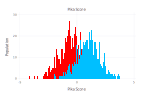

In [1]:
srand(22)
using Gadfly
n = 1000
todai = Array{Float64}([i + 1 for i in randn(n)])
wuni = Array{Float64}([i - 0.5 for i in randn(n)])
plot(
    layer(x = todai, Geom.histogram),
    layer(x = wuni, Geom.histogram, Theme(default_color=colorant"red")),
    Guide.xlabel("Pika Score"), Guide.ylabel("Population"), Guide.title("Pika Score")
)

赤がw大学のpika scoreで、青が東大のpika scoreです。

河原崎はこのデータを見て、**「東大に行くと学力が向上しそうだ！」**と思いました。

彼はこの仮説を検証するために、学生時代に習った回帰分析を使ってpika scoreを東大生のダミー変数と定数項に回帰してみることにしました。

回帰式は下のようになります。

<div style="text-align: center;">
$ pika_{i} = \alpha + {\beta}*todai_{i} + \epsilon_{i}$
</div>

結果は以下のようでした。

In [2]:
dummy = ones(2n)
dummy[1001:end] = 0
pika = [todai; wuni]
X = reshape([ones(2n) dummy], 2n, 2)
slope_coef = (inv(X' * X) * X') * pika
coef = ("alpha", "beta")
for i in 1:length(coef)
    c = coef[i]
    d = slope_coef[i]
    println("$c = $d")
end

alpha = -0.5207758568352845
beta = 1.5139362205338938


t値等も合わせて結果を表記すると以下のようになります。

[上の回帰分析](http://imgur.com/WwLhXgg "単回帰分析")

**「東大ダミーは有位に正だ！やっぱり東大に行くと学力が向上するんだ！」**と河原崎は叫びました。

しかし、経営学者の正田がこれにまったをかけます。

**「東大生はもとからW大学の学生よりも頭がいいんだから、その結果は東大に入ったことによる学力向上が測定されているとは言えないんじゃない？」**

たしかにその通りです。
しかし、河原崎はこれ以上の良い方法を知りません。

二人でうんうん唸っていると、哲学者の隅田がやってきて、こう言いました。

**「RDがあるやんけ」**

### RD

2013年度東京大学文科Ⅲ類の合格最低点は**347.2111**点でした。つまり、**347.2111**点を0.0001点でも上回った受験者は東大に合格し、0.0001点でも下回った受験者は東大には行くことはできませんでした。

RDはこの事実を使って、**347.211点をわずかに超えて合格した人**と、**わずかに下回って不合格になった人**とで従属変数を比較する手法です。

今、A君の合計得点が**348点**で、B君の合計得点が**347点**だとしましょう。

A君はめでたく東大に合格できましたが、B君は残念ながら不合格、滑り止めのW大学に通うことになりました。

さて、この二人について先ほど正田が述べた理屈は当てはまるでしょうか？

二人の得点差はわずかに1点。これはセンター試験の国語で1問落としたとか、世界史でたまたま直前に見てたところが出たとか、そのぐらいの偶然で十分に生まれる差です。

しかし、このわずか1点によって彼らが後の4年間を過ごす大学が変わってくるわけです。

ここで東大に入ることの学力向上への効果を見たいわけですから、東大入学は**処置**であります。

すなわち、**ほとんど能力に差のない二人に処置の割り当てがランダムに行われる**、という状況がここには存在しているわけです。

これがまさに自然実験であり、擬似的なランダム化比較実験が行われていると解釈できる状況です。

Angristでやった通り、ランダム化が行われていれば処置は潜在変数と独立となるため、処置群と対照群とで従属変数の平均値を比較すれば、それを平均的な因果効果として算出することができます。

今回の文脈で言えば、A君とB君のPika Scoreの点を比べれば、それは東大で勉強したことによる因果効果を算出している、ということです。

以下で実際のデータを模して作った擬似データを使ってこの状況をグラフにします。

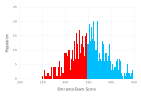

In [3]:
# 前期試験の得点分布作成

using Gadfly
srand(22)

cut = 347.211
n_1 = 500
n_2 = 300
n_3 = 150
n_4 = 50
n_array = [n_1, n_2, n_3, n_4]

pop_todai = Array(Float64)
for (i, n) in enumerate(n_array)
    pop_todai = [pop_todai ; [j*25 + cut + 25*(i-1) for j in rand(n)]]
end
pop_todai = Array{Float64}(pop_todai[2:end])

pop_w = Array(Float64)
for (i, n) in enumerate(n_array)
    pop_w = [pop_w ; [cut - j*25 - 25*(i-1) for j in rand(n)]]
end
pop_w = Array{Float64}(pop_w[2:end])

plot(
layer(x = pop_todai, Geom.histogram),
layer(x = pop_w, Geom.histogram, Theme(default_color=colorant"red")),
Guide.xlabel("Entrance Exam Score"), Guide.ylabel("Population")
)

the effect of attend to todai on pika score is 1.6033825113629998


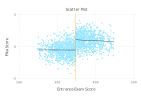

In [4]:
using DataFrames
using GLM

# 前期試験の得点とpika scoreの散布図作成
s_1 = reshape(pop_todai,1000,1)
s_2 = reshape(pop_w,1000,1)
score = vcat(s_1, s_2)
data = hcat(X, pika)
data = hcat(data, score)
n = 1000

# 回帰直線
d_todai = DataFrame(X = pop_todai, Y = todai)
result_todai = lm(Y ~ X, d_todai)
pre_todai = predict(result_todai)
d_w = DataFrame(X = pop_w, Y = wuni)
result_w = lm(Y ~ X, d_w)
pre_w = predict(result_w)

# plot
todai_layer = layer(x = pop_todai, y = pre_todai, Geom.line, Theme(default_color = colorant"black"))
w_layer = layer(x = pop_w, y = pre_w, Geom.line, Theme(default_color = colorant"black"))

gap = 1.98914-0.0026296*347.211 - (-0.45469-0.000209033*347.211)
println("the effect of attend to todai on pika score is $gap")

plot(x = score, y = pika, todai_layer, w_layer, xintercept=[347.211], 
    Scale.x_continuous(minvalue= 200, maxvalue=500),
    Geom.vline(color = colorant"orange"),
    Geom.point,
    Guide.xlabel("Entrance Exam Score"), Guide.ylabel("Pika Score"), Guide.title("Scatter Plot"),
    Theme(default_point_size = 1.5pt)
)

上の散布図をみてください。

オレンジの線が合格最低点である**347.211点**です。

オレンジの線を境にして、左側では低めに、右側では高めにpika scoreが出ていることが見て取れるでしょう。先ほど説明した状況になっているのがわかりますか？

ここでは東大に入学するという処置を受けられるか否かの境でpika scoreが不連続となっているのですね。

後の手順は簡単です。

オレンジ線の左側のデータのみで線形回帰を行いcut off(ここでは347.211点)における予測値を算出し、右側においても同様の手順でcut off における予測値を算出します。その時の予測値の差が求めている因果効果です。

ただ、一点注意しなくてはならない点があります。

それはどのデータまでを使うのか、という問題です。

知りたい因果効果が現出するのがオレンジ線上であることを考えると、前期試験の点数がとても高い学生や、極端に低い学生のデータは今必要ではありません。

私たちが純粋に知りたいのは、**左側で作った予測値のオレンジ線における極限値と右側で作った予測値のオレンジ線における極限値の差**です。

それゆえにオレンジ線の短い区間のデータのみに注目して切片を予測するのは理にかなったことといえます。

しかし、ある程度遠くのデータまで含めないと推定値が安定しないこともまた事実です。

RDにおいては、このジレンマの中で**最適なbandwidthすなわちデータを用いる幅を決定することが肝となってきます。**

その際に理論的な背景を与えるのが**Local Linear Regression**です。以下ではこのLocal Linear Regressionについて解説し、上のデータを少し変えて最適なbandwidthを実際に求めてみたいとおもいます。

### Local Linear Regression

上のデータは面白くないので、相関をつけます。さらに人数を実際に近づけて合格者400人、不合格者400人にします。
以下のモデルでpika scoreを算出し、上と同様のプロットを行います

<div style="text-align: center;">
$ pika_{i} = 10*{\rm log}(score_{i})+ \epsilon_{i} \\
pika_{i} = 9.8 * {\rm log}(score_{i})+ \epsilon_{i}$
</div>

the effect of the attend to todai on pika score is 0.9455299543999942


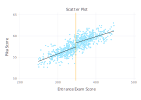

In [12]:
srand(22)

# パッケージインストール
using DataFrames
using GLM
using Gadfly

# データ作成
srand(22)
n = 400
cutoff = 347.211
n_1 = n/2
n_2 = 3n/10
n_3 = 3n/20
n_4 = n/20
n_array = Int64[n_1, n_2, n_3, n_4]
pop_todai = Array(Float64)
for (i, r) in enumerate(n_array)
    pop_todai = [pop_todai ; [j*25 + cutoff + 25*(i-1) for j in rand(r)]]
end
pop_todai = Array{Float64}(pop_todai[2:end])
pop_w = Array(Float64)
for (i, r) in enumerate(n_array)
    pop_w = [pop_w ; [cutoff - j*25 - 25*(i-1) for j in rand(r)]]
end
pop_w = Array{Float64}(pop_w[2:end])
s_1 = reshape(pop_todai,n,1)
s_2 = reshape(pop_w,n,1)
score = vcat(s_1, s_2)
newpika = Array(Float64, 2n)
for i in 1:2*n
    if i <= n
        newpika[i] =   10*log(score[i]) + randn()
        else newpika[i] =  9.8*log(score[i])+ randn()
    end
end

# 回帰直線
d_todai = DataFrame(X = score[1:n], Y = newpika[1:n])
result_todai = lm(Y ~ X, d_todai)
pre_todai = predict(result_todai)
d_w = DataFrame(X = score[n + 1:end], Y = newpika[n + 1 : end])
result_w = lm(Y ~ X, d_w)
pre_w = predict(result_w)

gap = 48.7327 + 0.0278084*347.211 - (45.4853  + 0.034438*347.211)
println("the effect of the attend to todai on pika score is $gap")

# plot
todai_layer = layer(x = pop_todai, y = pre_todai, Geom.line, Theme(default_color = colorant"black"))
w_layer = layer(x = pop_w, y = pre_w, Geom.line, Theme(default_color = colorant"black"))

plot(x = score, y = newpika, todai_layer, w_layer, xintercept=[347.211], 
    Scale.x_continuous(minvalue= 200, maxvalue=500),
    Geom.vline(color = colorant"orange"),
    Geom.point,
    Guide.xlabel("Entrance Exam Score"), Guide.ylabel("Pika Score"), Guide.title("Scatter Plot"),
    Theme(default_point_size = 1.5pt)
)


local linear regressionは、その名の通り一部のデータを使って線形回帰を行う手法です。RDの文脈では、cut off周囲のデータのみを使って左側と右側で二つの線形回帰を行います。推定された係数をもとにcut offにおける推定値の差を算出し、それを持って処置の効果とする手法です。

その際にどこまでを**周囲**とするか、すなわち**band width**を決めなくてはなりません。一般にこれは恣意的に決めるものではなく、data drivenな手法で求めるものされています。

band widthの決定には主に二つの手法が存在します。

1つ目はRule of Thumbで初期のband widthを決定し、それを改善していくもの。

2つ目はcross validationを行って、平均二乗誤差を最小にするband widthを選択するものです。

今回は2つ目の手法を紹介します。

cross validationとは一般に以下のような手法を指します。

1. 既存のデータをテスト用と学習用に分割する
2. 学習用データを用いてパラメータを推定する
3. 推定したパラメータをもとに推定値を算出し、テスト用のデータでその推定精度を確認する

Local Linear Regressionの文脈では、これは以下の用に用いられます。

1. cut offを境に左側に適当なband width (h)をとる
2. band widthに含まれるデータをN個として、1つのデータを除いたN-1個のデータで回帰分析を行う
3. 上で得られた回帰直線をもとに、除いたデータの推定値を算出し、実データとの差を保存する
4. 2,3の作業をband widthに含まれるすべての点に対して行い、3で得た差の二乗の平均を$CV(h)$とする
5. 複数のband widthに対して上記の作業を行い、$CV(h)$を最小にするhをband widthとして選択する

では、以下で実際にband widthを選択してみましょう。


In [18]:
# パッケージインストール
using DataFrames
using GLM

# データ作成
srand(22)
n = 400
cutoff = 347.211
n_1 = n/2
n_2 = 3n/10
n_3 = 3n/20
n_4 = n/20
n_array = Int64[n_1, n_2, n_3, n_4]
pop_todai = Array(Float64)
for (i, r) in enumerate(n_array)
    pop_todai = [pop_todai ; [j*25 + cutoff + 25*(i-1) for j in rand(r)]]
end
pop_todai = Array{Float64}(pop_todai[2:end])
pop_w = Array(Float64)
for (i, r) in enumerate(n_array)
    pop_w = [pop_w ; [cutoff - j*25 - 25*(i-1) for j in rand(r)]]
end
pop_w = Array{Float64}(pop_w[2:end])
s_1 = reshape(pop_todai,n,1)
s_2 = reshape(pop_w,n,1)
score = vcat(s_1, s_2)
newpika = Array(Float64, 2n)
for i in 1:2*n
    if i <= n
        newpika[i] =   10*log(score[i]) + randn()
        else newpika[i] =  9.8*log(score[i])+ randn()
    end
end

# cross validation
band_widthes = Float64[0.5, 1.0, 3.0, 5.0, 10.0, 20.0]
validation = Array{Float64}(length(band_widthes))
data = DataFrame(Y = newpika, X = squeeze(score',tuple(1)))

for (t, i) in enumerate(band_widthes)
    gaps = Float64[]
    temp_d = data[cutoff .> data[2] .> cutoff-i, :]
    temp_f = data[cutoff .> data[2] .> cutoff-i, :]
    
    for j in 1:size(temp_d)[1]
        temp_d[j, 1] = NA
        independent = temp_f[j, 2]
        dependent = temp_f[j, 1]
        temp_res = lm(Y ~ X, temp_d)
        predictval = predict(temp_res, [1, independent]')
        squared_gap = ((dependent - predictval)[1])^2
        push!(gaps, squared_gap)
        temp_d[j, 1] = dependent
    end
    
    validation[t] = mean(gaps)
end
band = band_widthes[indmin(validation)]
for (i, n) in enumerate(band_widthes)
    println("band = $n", validation[i])
println("selected band width is $band")

[1.8740761083701034,1.4150357114945884,0.811762326527483,1.5800501351360665,1.26417799309661,1.3654867429953117]
selected band width is 3.0


1234567

In [5]:
d=DataFrame(X=[1,2,3],Y=[2,4,7])
OLS = lm(Y~X,d)
predict(OLS, [1, 2.5]')

1-element Array{Float64,1}:
 5.58333

In [7]:
typeof(d[1,2])

Int64